# Course 27666 AI-guided Protein Science

# Graph Machine Learning

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Multiomics-Analytics-Group/course_graph_machine_learning/blob/main/notebooks/PyG_introduction.ipynb)

# PyTorch Geometric (PyG) Introduction

## Install PyG

In [6]:
# Uncomment and run the following commands if PyG is not installed.
#!pip install torch torch-geometric matplotlib

## 1. Creating a Simple Graph in PyTorch Geometric

The core Data class in PyG allows you to represent a single graph with attributes like:

    x: Node feature matrix of shape [N,F] (optional).
    
    edge_index: Connectivity in COO format with shape [2,𝐸], where 𝐸 is the number of edges.
    
    edge_attr: Edge feature matrix (optional).
    
    y: Graph- or node-level labels (optional).

PyG also supports handling datasets, which are collections of graphs.

In [ ]:
import torch
from torch_geometric.data import Data
from torch_geometric.utils import from_networkx, to_networkx
import networkx as nx
import matplotlib.pyplot as plt

# Define node features and edge connections
num_nodes = 4
x = torch.tensor([[1], [2], [3], [4]], dtype=torch.float)  # Node features (4 nodes, 1 feature each)
edge_index = torch.tensor([
    [0, 1, 2, 3],  # Source nodes
    [1, 0, 3, 2]   # Target nodes
], dtype=torch.long)  # Edge list

# Create a PyG Data object
data = Data(x=x, edge_index=edge_index)

print("Graph Information:")
print(data)
print(f"Number of nodes: {data.num_nodes}")
print(f"Number of edges: {data.num_edges}")

## 2. Converting a NetworkX Graph to PyG


Converted NetworkX Graph:
Data(edge_index=[2, 8], feature=[4, 1], num_nodes=4, x=[4, 1])


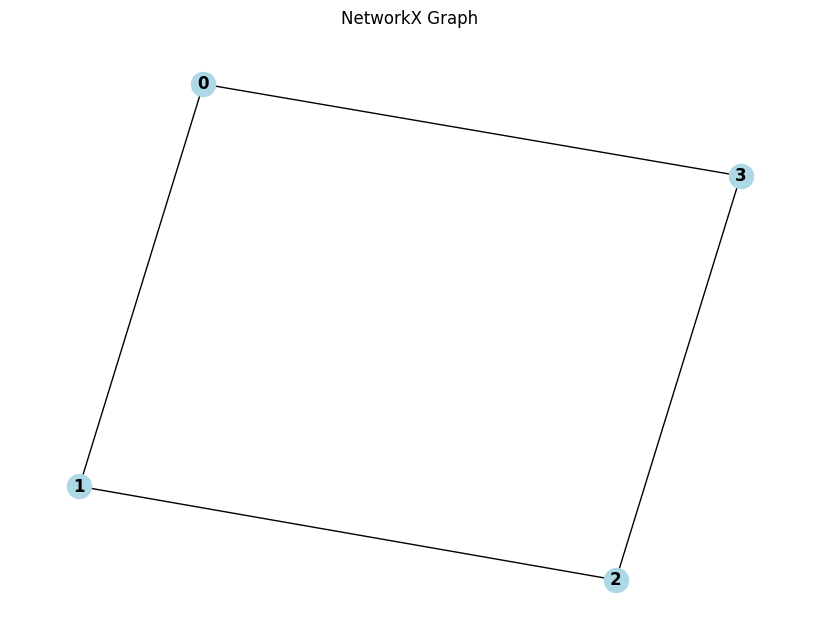

In [7]:
# Create a NetworkX graph
G = nx.Graph()
G.add_nodes_from([
    (0, {"feature": [1.0]}),
    (1, {"feature": [2.0]}),
    (2, {"feature": [3.0]}),
    (3, {"feature": [4.0]})
])
G.add_edges_from([(0, 1), (1, 2), (2, 3), (3, 0)])

# Convert the NetworkX graph to a PyG Data object
data_from_nx = from_networkx(G)
data_from_nx.x = torch.tensor([G.nodes[node]["feature"] for node in G.nodes()], dtype=torch.float)

print("\nConverted NetworkX Graph:")
print(data_from_nx)

# Visualize the NetworkX graph
plt.figure(figsize=(8, 6))
nx.draw(G, with_labels=True, node_color='lightblue', font_weight='bold')
plt.title("NetworkX Graph")
plt.show()

## 3. Using PyG Datasets

In [17]:
from torch_geometric.datasets import KarateClub

# Load the Karate Club dataset
dataset = KarateClub()
print("\nDataset Information:")
print(dataset)

data = dataset[0]  # Get the first (and only) graph in the dataset
print("\nKarate Club Graph:")
print(data)
print(f"Number of nodes: {data.num_nodes}")
print(f"Number of edges: {data.num_edges}")
print(f"Node features shape: {data.x.shape}")
print(f"Number of classes: {data.y.unique().size(0)}")


Dataset Information:
KarateClub()

Karate Club Graph:
Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])
Number of nodes: 34
Number of edges: 156
Node features shape: torch.Size([34, 34])
Number of classes: 4


### Splitting into Training and Test

The KarateClub dataset is often used as a toy dataset for small-scale experiments. By default, it includes a single graph and has train_mask for semi-supervised learning. However, it doesn't include a predefined test_mask, leaving it to the user to define their own train-test split.

In [18]:
if not hasattr(data, 'test_mask'):
    num_nodes = data.num_nodes
    # Create a mask for the test set (e.g., the last 20% of nodes)
    train_test_split = int(0.8 * num_nodes)  # 80% train, 20% test
    data.train_mask = torch.zeros(num_nodes, dtype=torch.bool)
    data.test_mask = torch.zeros(num_nodes, dtype=torch.bool)

    # Assign the first 80% of nodes to the training set
    data.train_mask[:train_test_split] = True

    # Assign the last 20% of nodes to the test set
    data.test_mask[train_test_split:] = True

## 4. Training a Simple GCN

### Define a simple GCN model

In [19]:
from torch_geometric.nn import GCNConv
from torch.nn import Linear
import torch.nn.functional as F


class GCN(torch.nn.Module): #torch.nn.Module, PyTorch's base class for all neural networks.
    def __init__(self, input_dim, hidden_dim, output_dim): 
        '''The __init__ method initializes the model's layers and attributes.
        input_dim: The size of the input features for each node.
        hidden_dim: The size of the hidden layer.
        output_dim: The number of output classes (for classification tasks) or the size of output features.'''
        super().__init__()
        # Defines the first graph convolution layer (GCNConv) to transform node features from input_dim to hidden_dim.
        self.conv1 = GCNConv(input_dim, hidden_dim)
        # Defines the second graph convolution layer to transform node features from hidden_dim to output_dim.
        self.conv2 = GCNConv(hidden_dim, output_dim) 

    def forward(self, x, edge_index):
        '''This method defines the forward pass of the model. It takes:
        x: Node features of shape [num_nodes, input_dim].
        edge_index: Graph connectivity in Coordinate format (efficiency sparse matrices), of shape [2, num_edges].'''
        
        # Applies the first graph convolution layer to the input features x using the graph structure edge_index.
        # The output x has a shape of [num_nodes, hidden_dim]
        x = self.conv1(x, edge_index)
        # Applies the ReLU activation function element-wise to the output of the first layer.
        x = F.relu(x)
        # Applies the second graph convolution layer to the input features x using the graph structure edge_index.
        # The output x has a shape of [num_nodes, hidden_dim]
        x = self.conv2(x, edge_index)
        
        return F.log_softmax(x, dim=1)


### Instantiate the model

In [20]:
input_dim = dataset.num_features
hidden_dim = 16
output_dim = dataset.num_classes
model = GCN(input_dim, hidden_dim, output_dim)

### Define optimizer and loss function

In [21]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

### Training loop

In [22]:
model.train()
for epoch in range(100): # This runs the training loop for 100 iterations (epochs).
    optimizer.zero_grad() # Clears the gradients from the previous epoch to avoid accumulating gradients from multiple backward passes. PyG accumulates by default. 
    
    # Forward pass
    # Passes the input features data.x (node features) and the graph connectivity data.edge_index (edges) through the model
    # Returns the log probabilities for each node. Its shape is [num_nodes, num_classes]
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute loss
    loss.backward()  # Backward pass
    optimizer.step()  # Update parameters

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

Epoch 10, Loss: 1.1191
Epoch 20, Loss: 0.7986
Epoch 30, Loss: 0.5340
Epoch 40, Loss: 0.3408
Epoch 50, Loss: 0.2131
Epoch 60, Loss: 0.1333
Epoch 70, Loss: 0.0874
Epoch 80, Loss: 0.0616
Epoch 90, Loss: 0.0468
Epoch 100, Loss: 0.0377


## 5. Evaluating the Model

### Evaluate the model

In [24]:
model.eval()
out = model(data.x, data.edge_index)  # Forward pass for all nodes
pred = out.argmax(dim=1)  # Predicted classes

### Test accuracy

In [26]:
correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
acc = int(correct) / int(data.test_mask.sum())
print(f"Test Accuracy: {acc:.4f}")

Test Accuracy: 0.8571


## 6. Visualizing Node Embeddings

### Visualize node classifications

/var/folders/92/ygd4xg0120nc10qf_vg3crnm0000gp/T/ipykernel_69498/2332713896.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  nx.draw(nx_graph, with_labels=True, node_color=color_map, cmap=plt.cm.get_cmap('Set1'))


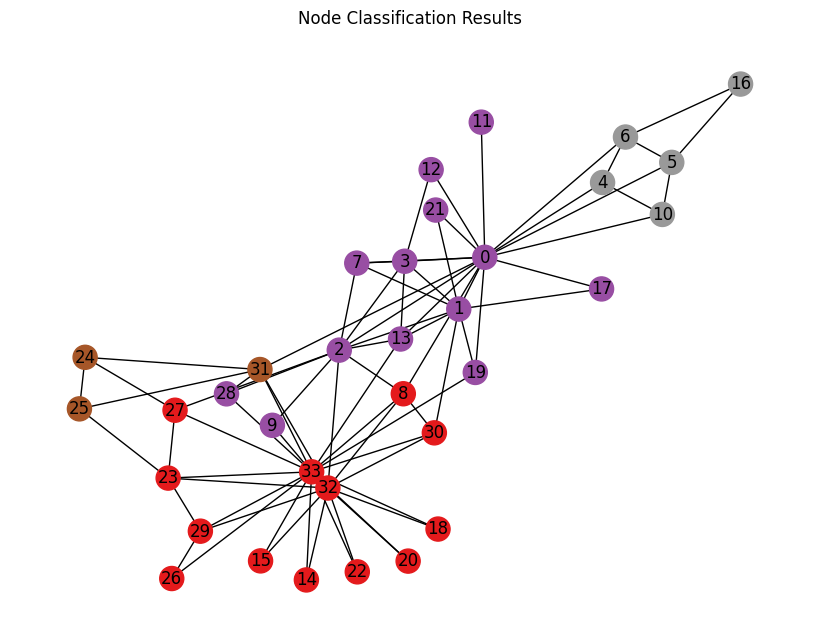

In [25]:
plt.figure(figsize=(8, 6))
color_map = pred.tolist()
nx_graph = to_networkx(data, to_undirected=True)
nx.draw(nx_graph, with_labels=True, node_color=color_map, cmap=plt.cm.get_cmap('Set1'))
plt.title("Node Classification Results")
plt.show()